In [1]:
import random
import numpy as np
import matplotlib
import numba
import time
import multiprocessing as mp
from numba import jit, prange
from numba import config, njit, threading_layer
from matplotlib import pyplot as plt

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@njit
def demand(p1,p2):
        if p1 < p2:
            d = 1 - p1
        elif p1 == p2:
            d = 0.5 * (1 - p1)
        else:
            d = 0
        return d

In [3]:
x = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1])

In [4]:
@njit
def player3(prices, Q, epsilon, p2):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [5]:
@njit
def player4(prices, Q, epsilon, prev):
    if random.uniform(0,1) < epsilon:
        p4 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        p4 = int(np.argmax(Q[:,prev[0,1]]))
    #print('type:', type(p4))
    return p4

In [6]:
@njit
def update(Q, prev, alpha, delta, prices, indic):
    if indic == 1: 
        p1 = prices[prev[0,0]]
        p2 = prices[prev[1,0]]
        p22 = prices[prev[1,1]]
        pe1 = Q[prev[0,0],prev[1,0]]
        ne1 = p1*demand(p1,p2) + delta* p1*demand(p1,p22) + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
        Q[prev[0,0], prev[1,0]] = (1-alpha) * pe1 + alpha * ne1
        #print('GAME player 1 ne and pe', ne1, pe1)
    else: 
        p1 = prices[prev[1,0]]
        p2 = prices[prev[0,0]]
        p22 = prices[prev[0,1]]
        pe2 = Q[prev[1,0],prev[0,0]]
        ne2 = p1*demand(p1,p2) + delta* p1*demand(p1,p22) + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe2 + alpha * ne2

In [7]:
@njit
def present_update(Q, prev, alpha, prices):
    p1 = prices[prev[1,0]]
    p2 = prices[prev[0,0]]
    p22 = prices[prev[0,1]]
    pe2 = Q[prev[1,0],prev[0,0]]
    ne2 = p1*demand(p1,p2)  
    Q[prev[1,0], prev[0,0]] = (1-alpha) * pe2 + alpha * ne2

In [8]:
@njit    
def profit(pris1, pris2):
    return pris1*demand(pris1,pris2)

In [9]:
def opti(Q, Q2, lastp, prev1, prices, alpha, delta, theta, current_round):
    Q_here = np.copy(Q)
    init_q = Q
    firstq = Q_here[prev1, lastp]
    tol = 1
    p1_indic = prev1
    p2_indic = lastp
    p2 = prices[lastp]
    #print('p2:',p2)
    while tol > 0.0001:
        epsilon = (1-theta)**current_round
        p1 = prices[p1_indic]
        p2_1_indic = np.argmax(Q2[:,p1_indic])
        #p2_1_indic = player3(prices, Q2, epsilon, p1_indic)
        p2_1 = prices[p2_1_indic]
        pe = Q_here[p1_indic, p2_indic]
        ne = p1 * demand(p1,p2) + delta * p1 * demand(p1,p2_1) + delta**2 * Q_here[np.argmax(Q_here[:,p2_1_indic]),p2_1_indic]
        Q_here[p1_indic, p2_indic] = (1-alpha) * pe + alpha * ne
        p2 = p2_1
        p2_indic = p2_1_indic
        current_round+=2
        p1_indic = player3(prices, Q_here, epsilon, int(p2_indic))
     
        tol = abs(pe - Q_here[p1_indic, p2_indic])
        
    finalp1 = np.argmax(Q_here[:,lastp])  
    maxp = Q_here[finalp1, lastp]
    #print('maxp:', maxp)
    #print('firstq:', firstq)
    opt = firstq/maxp
    print('convergence diff:', init_q-Q_here)
    
    if (opt > 1):
        print("PERIOD", current_round)
        print('maxp:', maxp, 'p2:', p2)
        print('old:', firstq, 'p1start: ', prices[prev1], 'p1 slut:', prices[finalp1])
  
    return opt

In [10]:
@njit
def game(prices, periods, alpha, theta, delta):
    a = len(prices)
    Q_table = np.zeros((a, a))
    Q_table2 = np.zeros((a, a))
    optimality = 0.0
    #print('CHECK', int(periods/2)-1, 'starting a run with ', periods, ' periods')
    p_ipriser =np.zeros(int(periods/2)-1)
    p_jpriser =np.zeros(int(periods/2)-1)
    prev_p = np.zeros((2,2),dtype=numba.int64)
    prof_arr = np.zeros(int(periods-2))
    prof_arr2 = np.zeros(int(periods-2))

    for i in range(1):
        for j in range(1):
            prev_p[i,j] = np.random.choice(len(prices))
    t = 3
    i_counter = 0
    j_counter = 0
    stepsize = periods/50
    step_counter = 0
    opt_arr = np.zeros(int(periods/2/5000-1))
    b = 0
    unchanged = 0
    change1 = np.zeros(len(prices))
    change2 = np.zeros(len(prices))
    temp_br1 = np.zeros(len(prices))
    temp_br2 = np.zeros(len(prices))
    for t in range(t, periods+1):
        epsilon = (1-theta)**t
    
        if t % 2 != 0: 
            update(Q_table, prev_p, alpha, delta, prices,1)
            p_i = player3(prices, Q_table, epsilon, prev_p[1,1])
            #forced deviation
            if t == 485001 and np.all(prev_p == 3): 
                print('im deviating!!!')
                p_i = prev_p[1,1]-1
                unchanged = 1
            prev_p[0,0] = prev_p[0,1]
            prev_p[0,1] = p_i
            prev_p[1,0] = prev_p[1,1]
            p_ipriser[i_counter] = (prices[p_i])
            i_counter += 1
            #print('Spiller 1 tur: p:', prices[p_i],' p_j: ', prices[prev_p[1,1]],'iteration:', t,'Q_table: \n', Q_table)
            prof_arr2[t-3] = profit(prices[prev_p[1,1]], prices[p_i])
            prof_arr[t-3] = profit(prices[prev_p[0,1]], prices[prev_p[1,1]])
            '''
            if step_counter == stepsize:
                    #print("t and stepsize", t-3, stepsize)
                    opt_arr[b] = opti(Q_table, Q_table2, prev_p[1,1], prev_p[0,1], prices, alpha, delta, theta, t)
                    step_counter = 0
                    b += 1
            step_counter +=1
            '''
     
                
                
      
        else: 
            update(Q_table2, prev_p, alpha, delta, prices, 0)
            #present_update(Q_table2, prev_p, alpha, prices)
            #p_j = tit4tat(prev_p)
            p_j = player4(prices, Q_table2, epsilon, prev_p)
            #p_j = player2(prices)
            #p_j = player6(prices, Q_table2, epsilon, prev_p)
            #p_j = gamma_player(prices, Q_table2, epsilon, prev_p)
            #p_j = player6(prices, Q_table2, epsilon, prev_p)
            prev_p[1,0] = prev_p[1,1]
            prev_p[1,1] = p_j
            prev_p[0,0] = prev_p[0,1]
            p_jpriser[j_counter] = (prices[p_j])
            j_counter += 1
            #print('Spiller 2 tur: p:', prices[p_j], 'p_i', prices[prev_p[0,1]],' iteration: ', t,'Q_table2: \n', Q_table2)
            prof_arr[t-3] = profit(prices[prev_p[0,1]], prices[p_j])
            prof_arr2[t-3] = profit(prices[p_j], prices[prev_p[0,1]])
            #step_counter +=1
        '''     
        if t == 400000:
            for i in range(len(prices)):
                change1[i] = int(np.argmax(Q_table[:,i]))
                change2[i] = int(np.argmax(Q_table2[:,i]))
        elif t > 400000:
            for i in range(len(prices)):
                temp_br1[i] = int(np.argmax(Q_table[:,i]))
                temp_br2[i] = int(np.argmax(Q_table2[:,i]))
            if (np.array_equal(temp_br1,change1) == False) or (np.array_equal(temp_br2,change2) == False):
                unchanged = 1
                #print('first check', (np.array_equal(temp_br1,change1) == False), temp_br1, change1)
                #print('second check',(np.array_equal(temp_br2,change2) == False), temp_br2, change2)
        '''        
    #print('argmax arrays', temp_br1, change1,(np.array_equal(temp_br1,change1) == False) )
    #print('argmax arrays', temp_br2, change2, (np.array_equal(temp_br2,change2) == False))
                
    #optimality = opti(Q_table, p_j, p_i, prices, alpha, 0.95)
    #print ('B', b)
    
    #print('q_table2', Q_table2)
    return prof_arr, p_ipriser, p_jpriser, Q_table2, opt_arr, prof_arr2, unchanged

In [11]:
def many_games(prices, periods, alpha, theta, learners,delta):
    total_pro_arr = np.zeros((learners,periods-2))
    total_pro_arr2 = np.zeros((learners,periods-2))
    total_opt_arr = np.zeros((learners, 49))
    avg_profit = np.zeros(learners)
    avg_profit2 = np.zeros(learners)
    change_arr = np.zeros((1,25))
    change_arr2 = np.zeros((1,25))
    for i in range(learners):
        print('run #',i+1 ,'of ', learners , 'runs')
        proi, arri, arr1i, Q_ti, arr_opt_i, proi2, changes = game(prices, periods, alpha, theta, delta)
        total_pro_arr[i] = proi
        total_pro_arr2[i] = proi2
        total_opt_arr[i] = arr_opt_i
        avg_profit[i] = np.mean(proi[-10000:])
        avg_profit2[i] = np.mean(proi2[-10000:])
        print('changes=', changes)
        if changes == 1:
            print('Her er proi i udvalgte', proi[484991:485016:1]) 
            change_arr = np.vstack((change_arr, proi[484991:485016:1]))
            change_arr2 = np.vstack((change_arr2, proi2[484991:485016:1]))
        #print('avg profit firm 1 & 2', avg_profit, avg_profit2, 'længde', len(avg_profit2))
        #print('profitability1',proi[-10:])
        #print('profitability1',proi2[-10:])
        #print('pris1:', arri[-10:])
        #print('priser2:', arr1i[-10:])
    return total_pro_arr, total_opt_arr, total_pro_arr2, avg_profit, avg_profit2, change_arr, change_arr2

In [12]:
def delta_prof(avg_array1, avg_array2):
    together_array = np.vstack((avg_array1, avg_array2))
    together_array = np.mean(together_array, axis=0)
    delta_1 = np.zeros(len(together_array))
    for i in range(len(together_array)):
        delta_1[i] = ((together_array[i]) / (0.125))
    return delta_1

In [13]:
def delta_div(delta_arr):
    new_delt = np.zeros(5)
    for i in range(len(delta_arr)):
        if delta_arr[i] <=1 and delta_arr[i] > 0.9: 
            new_delt[4]+=1
        elif delta_arr[i] <=0.9 and delta_arr[i] > 0.8:
            new_delt[3]+=1
        elif delta_arr[i] <=0.8 and delta_arr[i] > 0.7:
            new_delt[2]+=1
        elif delta_arr[i] <= 0.7 and delta_arr[i] > 0.6:
            new_delt[1]+=1
        else:
            new_delt[0] +=1
    return new_delt

In [14]:
def moving_avg(fst_arr, snd_arr, window_size):

    moving_averages = []
    moving_averages2 = []
    i = 0
    while i < len(fst_arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(fst_arr[
        i:i+window_size]) / window_size
        window_average2 = np.sum(snd_arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        moving_averages2.append(window_average2)

        
        # Shift window to right by one position
        i += 1
    return moving_averages, moving_averages2

In [15]:
def end_prof(p1_prof, p2_prof):
    end_prof1 = np.mean(np.array(([i[-1000:] for i in p1_prof])), axis=1)
    end_prof2 = np.mean(np.array(([i[-1000:] for i in p2_prof])), axis=1)
    
    return end_prof1, end_prof2

In [16]:
many_profs, many_opt, many_profs2, delta_arr, delta_arr2, change_yes, change_yes2= many_games(x, 500000, 0.3, 0.0000276306393827805, 1000, 0.95)
#print('multi-dim prof', many_profs)
#print('many_opt:',many_opt)

print(change_yes2.shape)


#print('efter many_profs og str på arr er:', np.size(change_yes))
dev_arr = np.mean(change_yes, axis=0)
dev_arr2 = np.mean(change_yes2, axis=0)
firm1, firm2 = end_prof(many_profs, many_profs2,)
delta_done1= delta_prof(delta_arr, delta_arr2)
#print(delta_done1[-10:])
unique, counts = np.unique(change_yes, return_counts=True)
#print(np.asarray((unique, counts)).T)
#print('initiating run calculations')
attempt_time = time.time()

#many_profs, many_opt, many_profs2, delta_arr, delta_arr2, change_yes, change_yes2 =  many_games(x, 500000, 0.3, 0.0000276306393827805, 10, 0.95)
efter_time = time.time()
#print('ending run calculations. Total time: ', efter_time - attempt_time)

run # 1 of  1000 runs
changes= 0
run # 2 of  1000 runs
changes= 0
run # 3 of  1000 runs
changes= 0
run # 4 of  1000 runs
im deviating!!!
changes= 1
Her er proi i udvalgte [0.125      0.125      0.125      0.125      0.125      0.125
 0.125      0.22222222 0.         0.         0.         0.125
 0.125      0.125      0.125      0.125      0.125      0.125
 0.125      0.125      0.125      0.125      0.125      0.125
 0.125     ]
run # 5 of  1000 runs
changes= 0
run # 6 of  1000 runs
changes= 0
run # 7 of  1000 runs
changes= 0
run # 8 of  1000 runs
changes= 0
run # 9 of  1000 runs
changes= 0
run # 10 of  1000 runs
changes= 0
run # 11 of  1000 runs
changes= 0
run # 12 of  1000 runs
im deviating!!!
changes= 1
Her er proi i udvalgte [0.125      0.125      0.125      0.125      0.125      0.125
 0.125      0.22222222 0.         0.06944444 0.         0.
 0.125      0.125      0.125      0.125      0.125      0.125
 0.125      0.125      0.125      0.125      0.125      0.125
 0.125     ]
run 

starting moving averages


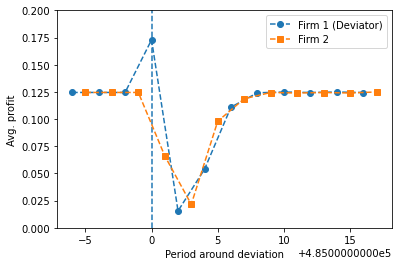

In [17]:
print('starting moving averages')
deviation_arr, deviation_arr2 = moving_avg(dev_arr, dev_arr2, 2)

deviation_t = np.arange(484994,485018, 2)
deviation_t2 = np.arange(484995,485019, 2)
deviation_arr = deviation_arr[0:24:2]
deviation_arr2 = deviation_arr2[1:25:2]
plt.plot(deviation_t, deviation_arr, '--o', label='Firm 1 (Deviator)')
plt.plot(deviation_t2, deviation_arr2, 's--', label='Firm 2')
plt.vlines(x=485000, ymin=0.00, ymax=0.2, linestyle = '--')
plt.xlabel("Period around deviation")
plt.ylabel("Avg. profit")
plt.ylim(0.00,0.2)
plt.legend()
plt.show()